# Zadania - klasyfikacja wieloklasowa

Celem zadań jest zbudowanie klasyfikatora rozpoznającego ręcznie zapisaną cyfrę 0-9 z pojedynczego czarno-białego obrazu. Zestaw danych, na których będziemy pracować to MNIST (https://en.wikipedia.org/wiki/MNIST_database).

MNIST zawiera ok. 70000 obrazów, każdy oznaczony cyfrą, którą przedstawia. Pojedyncze obrazy w tym zbiorze danych wyglądają np. tak: 

<img src="http://pavel.surmenok.com/wp-content/uploads/2014/07/mnistdigits.gif"/>

Zbiór jest już podzielony na zestawy treningowy i testowy. 

## MNIST

Pobierz cztery pliki `*-images-idx3-ubyte.gz` ze strony http://yann.lecun.com/exdb/mnist/ i rozpakuj (!) w tym samym katalogu, w którym znajduje się notatnik (pod Linuxem możesz wykorzystać skrypt `download.sh`). **Uwaga**: proszę nie wrzucać tych plików do swojego repozytorium.

1. Wyświetl w postaci tablicy oraz w postaci obrazka pierwsze pięć liczb. Wykorzystaj do tego funkcje `readMnist` i `showImage` (nie jest potrzebna znajomość ich działania).
1. Stwórz macierze dla zestawów treningowego i testowego, zawierające pierwsze 1000 obrazków każdy (wykorzystaj `maxItems` w funkcji `mnistMatrix`, podanie `maxItems=60000` wczyta wszystkie dane). Odpowiedz na pytania: ile cech ma każdy obrazek? Czym są te cechy? Jak przedstawione są etykiety w zbiorze testowym?

## Regresja logistyczna

1. Na podstawie materiałów z wykładu nr 5 zbuduj model wieloklasowej regresji logistycznej rozpoznający wszystkie 10 cyfr na podstawie pierwszych 1000 danych. Eksperymentuj z doborem parametrów w algorytmie GD. Uwaga: należy rozpocząć od małej liczby kroków, np. 100, i powoli zwiększać. Jaką osiągnięto poprawność (_accuracy_)?
1. Zwiększ liczbę danych treningowych do 10000, 20000 itd. Co się dzieje z algorytmem GD?
1. Zaimplementuj algorytm Batch-SGD (_Batch Stochastic Gradient Descent_), którego wykrzystasz w miejsce podstawowego algorytmu. Różnice między tymi algorytmami obrazują poniższe pseudokody:

   Gradient Descent
   ```
   for i in range(num_epochs):
       gradient = evaluate_gradient(J, data, thetas)
       thetas = thetas - alpha * gradient
   ```
   
   Batch Stochastic Gradient Descent
   ```
   for i in range(num_epochs):
       shuffle(data)
       for batch in get_batch(data, batch_size=50):
           gradient = evaluate_gradient(J, batch, thetas)
           thetas = thetas - alpha * gradient
    ```
    
    Gdzie `num_epochs` to liczba epok, a epoką nazywamy jednokrotne wykorzystanie wszystkich danych w zbiorze treningowym do nauki parametrów (do tej pory zakładaliśmy `num_epoch=1`).

1. Wykorzystaj Batch-SGD do zbudowania modelu na całosci danych treningowych (można zastosować jedną epokę i pominąć randomizację dla uzyskania stabilnych wyników). Jaką osiągnięto poprawność, dopasowując parametry `alpha`, `maxSteps` i `batchSize`? Zmiana których parametrów ma najmniejszy/największy wpływ na osiągany wynik? Które parametry są łatwe/trudne do dopasowywania?

In [295]:
import os
import struct
import numpy as np
import itertools

%matplotlib inline

def readMnist(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def showImage(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [296]:
def mnistMatrix(data, maxItems=1000):
    datalist = [t for t in data]
    m = maxItems
    n = 28 * 28 + 1
    X = np.matrix(np.zeros(m * n)).reshape(m, n)
    Y = np.matrix(np.zeros(m)).reshape(m, 1)
    for i, (label, image) in enumerate(datalist[:m]):
        X[i, 0] = 1 # bias term
        X[i, 1:] = image.reshape(28*28,)
        Y[i] = label
    return X, Y

## MNIST

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
[[ 5.]
 [ 0.]
 [ 4.]
 [ 1.]
 [ 9.]]


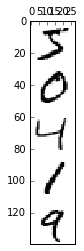

785


In [297]:
X, y = mnistMatrix(readMnist(), maxItems=60000)
X_test, y_test = mnistMatrix(readMnist(dataset='testing'), maxItems=60000)

print(X[:5])
print(y[:5])
showImage(X[:5, 1:].reshape(5*28, 28))

print(np.size(X[0]))

Każdy obrazek złożony jest z 785 cech, które wszystkie oprócz pierwszej (równej 1) są pikselami danego obrazka, a wartość cechy oznacza kolor, 0 - biały, 255 - czarny. Etykiety przedstawione są w postaci liczb całkowitych.

## Regresja logistyczna

In [298]:
def normalize(X):
    X[:,1:] = X[:,1:] / 255
    return X

def mapY(y, cls):
    m = len(y)
    yBi = np.matrix(np.zeros(m)).reshape(m, 1)
    yBi[y == cls] = 1.
    return yBi

def indicatorMatrix(y):
    classes = np.unique(y.tolist())
    m = len(y)
    k = len(classes)
    Y = np.matrix(np.zeros((m, k)))
    for i, cls in enumerate(classes):
        Y[:,i] = mapY(y, cls)
    return Y

def h(theta, X):
    return 1.0/(1.0 + np.exp(-X*theta))

def J(h, theta, X, y):
    m = len(y)
    h_val = h(theta,X)
    s1 = np.multiply(y, np.log(h_val))
    s2 = np.multiply((1 - y), np.log(1 - h_val))
    return -np.sum(s1 + s2, axis=0) / m

def dJ(h,theta,X,y):
    return 1.0/len(y)*(X.T*(h(theta,X)-y))

def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

def classify(thetas, X, debug=False):
    regs = np.array([(X*theta).item() for theta in thetas])
    if debug:
        print("regs  =", regs)
    probs = softmax(regs)
    if debug:
        print("probs =", np.around(probs,decimals=3))
    return np.argmax(probs), probs

def trainMaxEnt(X, Y, steps):
    n = X.shape[1]
    thetas = []
    for c in range(Y.shape[1]):
        YBi = Y[:,c]
        theta = np.matrix(np.zeros(n)).reshape(n,1)
        thetaBest, errors = GD(h, J, dJ, theta, 
                               X, YBi, alpha=0.1, eps=10**-4, maxSteps=steps)
        thetas.append(thetaBest)
    return thetas

def softmax(X):
    return np.exp(X) / np.sum(np.exp(X))

def calculateAcc(thetas, X_test, y_test):
    acc = 0.0
    for i in range(len(y_test)):
        cls, probs = classify(thetas, X_test[i])
        correctCls = int(y_test[i].item())
        if i < 6:
            print(correctCls, "  <=>", cls, " -- ", cls == correctCls, np.round(probs, 4).tolist())
        acc += correctCls == cls
    return acc

In [299]:
X_norm = normalize(X)
X_test_norm = normalize(X_test)
ind_y = indicatorMatrix(y)

In [300]:
thetas_100 = trainMaxEnt(X_norm[:1000], ind_y[:1000], 100)
print("\nAccuracy =", calculateAcc(thetas_100, X_test_norm[:1000], y_test[:1000])/len(X_test_norm[:1000]))

thetas_1000 = trainMaxEnt(X_norm[:1000], ind_y[:1000], 1000)
print("\nAccuracy =", calculateAcc(thetas_1000, X_test_norm[:1000], y_test[:1000])/len(X_test_norm[:1000]))

thetas_2000 = trainMaxEnt(X_norm[:1000], ind_y[:1000], 5000)
print("\nAccuracy =", calculateAcc(thetas_2000, X_test_norm[:1000], y_test[:1000])/len(X_test_norm[:1000]))

7   <=> 7  --  True [0.0032, 0.0004, 0.0042, 0.0073, 0.004, 0.0025, 0.0005, 0.9618, 0.0034, 0.0128]
2   <=> 6  --  False [0.1519, 0.0253, 0.2105, 0.0561, 0.0012, 0.2272, 0.2419, 0.0008, 0.0818, 0.0034]
1   <=> 1  --  True [0.0043, 0.8562, 0.0309, 0.0174, 0.0056, 0.0119, 0.0164, 0.0227, 0.0221, 0.0125]
0   <=> 0  --  True [0.9327, 0.0001, 0.0043, 0.0008, 0.0006, 0.0114, 0.0367, 0.0108, 0.0012, 0.0014]
4   <=> 4  --  True [0.0131, 0.0012, 0.0612, 0.0098, 0.7767, 0.0078, 0.0241, 0.0527, 0.0192, 0.0342]
1   <=> 1  --  True [0.0011, 0.9273, 0.0133, 0.0088, 0.002, 0.0047, 0.003, 0.0174, 0.0133, 0.009]

Accuracy = 0.772
7   <=> 7  --  True [0.0008, 0.0, 0.0014, 0.0026, 0.0004, 0.0003, 0.0, 0.992, 0.0006, 0.0017]
2   <=> 6  --  False [0.1438, 0.0086, 0.2102, 0.0375, 0.0001, 0.1991, 0.3421, 0.0001, 0.0575, 0.0009]
1   <=> 1  --  True [0.0011, 0.9373, 0.0175, 0.0069, 0.0017, 0.0027, 0.0076, 0.0123, 0.0085, 0.0045]
0   <=> 0  --  True [0.9829, 0.0, 0.0008, 0.0, 0.0, 0.0027, 0.0101, 0.0032, 0.0001

Dla 100 kroków accuracy wyniosło 0.772, dla 1000 - 0.812, dla 5000 również 0.812
Co w przypadku 10000?

In [269]:
thetas_10000 = trainMaxEnt(X_norm[:1000], ind_y[:1000], 10000)
print("\nAccuracy =", calculateAcc(thetas_10000, X_test_norm[:1000], y_test[:1000])/len(X_test_norm[:1000]))

thetas_20000 = trainMaxEnt(X_norm[:1000], ind_y[:1000], 20000)
print("\nAccuracy =", calculateAcc(thetas_10000, X_test_norm[:1000], y_test[:1000])/len(X_test_norm[:1000]))

7   <=> 7  --  True [0.0008, 0.0, 0.0014, 0.0026, 0.0004, 0.0003, 0.0, 0.992, 0.0006, 0.0017]
2   <=> 6  --  False [0.1438, 0.0086, 0.2102, 0.0375, 0.0001, 0.1991, 0.3421, 0.0001, 0.0575, 0.0009]
1   <=> 1  --  True [0.0011, 0.9373, 0.0175, 0.0069, 0.0017, 0.0027, 0.0076, 0.0123, 0.0085, 0.0045]
0   <=> 0  --  True [0.9829, 0.0, 0.0008, 0.0, 0.0, 0.0027, 0.0101, 0.0032, 0.0001, 0.0001]
4   <=> 4  --  True [0.0036, 0.0003, 0.0233, 0.0021, 0.9096, 0.0013, 0.0101, 0.0235, 0.0114, 0.0149]
1   <=> 1  --  True [0.0002, 0.9681, 0.0069, 0.0032, 0.0005, 0.0008, 0.0009, 0.0109, 0.0051, 0.0034]

Accuracy = 0.812
7   <=> 7  --  True [0.0008, 0.0, 0.0014, 0.0026, 0.0004, 0.0003, 0.0, 0.992, 0.0006, 0.0017]
2   <=> 6  --  False [0.1438, 0.0086, 0.2102, 0.0375, 0.0001, 0.1991, 0.3421, 0.0001, 0.0575, 0.0009]
1   <=> 1  --  True [0.0011, 0.9373, 0.0175, 0.0069, 0.0017, 0.0027, 0.0076, 0.0123, 0.0085, 0.0045]
0   <=> 0  --  True [0.9829, 0.0, 0.0008, 0.0, 0.0, 0.0027, 0.0101, 0.0032, 0.0001, 0.0001]
4 

Zwiększenie liczby kroków w znaczny sposób wydłuża czas działania algorytmu, ale w małym stopniu (lub wcale) poprawia skuteczność.

In [280]:
def get_batches(X, y, batch_size):
    batches = []
    m = X.shape[0]
    for i in range(0, m, batch_size):
        batches.append((X[i : i+batch_size], y[i : i+batch_size]))
    return batches

def batch_SGD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000, batch_size = 120):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    flag = True
    while flag:
        for batch_x, batch_y in get_batches(X, y, batch_size):
            theta = theta - alpha * fdJ(h, theta, batch_x, batch_y)
            errorCurr, errorPrev = fJ(h, theta, batch_x, batch_y), errorCurr
            if abs(errorPrev - errorCurr) <= eps:
                flag = False
                break
            if len(errors) > maxSteps:
                flag = False
                break
            errors.append([errorCurr, theta])
    return theta, errors

def batch_trainMaxEnt(X, Y, alpha, batch_size, steps):
    n = X.shape[1]
    thetas = []
    for c in range(Y.shape[1]):
        YBi = Y[:,c]
        theta = np.matrix(np.random.random(n)).reshape(n,1)
        thetaBest, errors = batch_SGD(h, J, dJ, theta, X, YBi, alpha=alpha, eps=10**-4, maxSteps=steps, batch_size=batch_size)
        thetas.append(thetaBest)
    return thetas

In [285]:
alphas = [0.02, 0.01, 0.1]
steps = [100, 1000, 10000]
batchSizes = [10, 100, 1000]

for alpha in alphas:
    for step in steps: 
        for batchSize in batchSizes:
            print('alpha: %f' % alpha)
            print('steps: %d' % step)
            print('batchSize: %d' % batchSize)
            batch_theta = batch_trainMaxEnt(X_norm, ind_y, alpha, batchSize, step)
            print("Accuracy = %f\n" % (calculateAcc(batch_theta, X_test_norm, y_test)/len(X_test_norm)))

alpha: 0.020000
steps: 100
batchSize: 10
7   <=> 7  --  True [0.0333, 0.0124, 0.0268, 0.0431, 0.0542, 0.0298, 0.0188, 0.6745, 0.0341, 0.0731]
2   <=> 6  --  False [0.1604, 0.0745, 0.1301, 0.1196, 0.0222, 0.1536, 0.1815, 0.0221, 0.1114, 0.0246]
1   <=> 1  --  True [0.037, 0.4057, 0.0783, 0.0761, 0.0412, 0.0597, 0.068, 0.0875, 0.0929, 0.0537]
0   <=> 0  --  True [0.5788, 0.0045, 0.0266, 0.0257, 0.027, 0.0552, 0.1384, 0.101, 0.0208, 0.0219]
4   <=> 4  --  True [0.0658, 0.0143, 0.0978, 0.049, 0.3767, 0.044, 0.0785, 0.1443, 0.05, 0.0795]
1   <=> 1  --  True [0.022, 0.514, 0.0578, 0.0649, 0.0294, 0.0443, 0.0379, 0.0922, 0.0878, 0.0496]
Accuracy = 0.955767

alpha: 0.020000
steps: 100
batchSize: 100
7   <=> 7  --  True [0.0453, 0.0337, 0.0409, 0.0494, 0.0555, 0.0385, 0.0237, 0.5607, 0.046, 0.1063]
2   <=> 2  --  True [0.1108, 0.0801, 0.2087, 0.1712, 0.0147, 0.0934, 0.1981, 0.0141, 0.0903, 0.0187]
1   <=> 1  --  True [0.0452, 0.318, 0.1057, 0.0966, 0.0512, 0.069, 0.0774, 0.071, 0.1013, 0.0646]


Uzyskano wyniki z przedziału 0.947683 - 0.981150. 

Dla porównania, wybieram dane z steps=100 i batchSize=10.
Wówczas, dla alfy równej 0.02 otrzymujemy wartość 0.955767, dla 0.01 - 0.951400, natomiast dla 0.1 - 0.964533. Widzimy, że najlepsze wyniki daje wartość 0.1

Przy ustalonych parametrach alfa=0.01 i batchSize=100 otrzymujemy accurancy 0.947683 dla 100 kroków, 0.964583 dla 1000 kroków oraz 0.965483 dla 10000 kroków. Jak widać, po osiągnięciu pewnego punktu zwiększanie liczby kroków nie wpływa na wynik.

Przy ustalonych parametrach alfa=0.01 i maxSteps=1000 otrzymalismy accurancy 0.973983 dla batchSize=10, 0.964583 dla batchSize=100 oraz 0.963883 dla batchSize=1000. Jak widać, im mniejsza wartość tego parametru, tym lepiej.

Podsumowując, największą różnice obserwujemy przy zmianie parametru batchSize, najmniejszą - maxSteps. Najłatwiej jest ustalić parametr maksymalnej liczby kroków właśnie, wystarczy przyjąć np. maxSteps = 1000. Cały problem polega na odpowiednim dostrojeniu ze sobą parametrów alfa i batchSize. Można zauważyć pewną prawidłowość: dla stosunkowo dużej wartości alfa lepsze wyniki uzyskamy dobierając większe batchSize, natomiast dla małej alfy lepiej dobrać mały batchSize.